# Running and Plotting LightCones

This tutorial follows on from the [coeval cube tutorial](coeval_cubes), and provides an introduction to creating lightcones with ``21cmFAST``. If you are new to ``21cmFAST`` you should go through the coeval cube tutorial first.

The main entry point into creating lightcones in 21cmFAST is the ``run_lightcone`` function. The function takes a few different arguments, most of which will be familiar to you if you've gone through the coeval tutorial. All simulation parameters can be passed (i.e. ``user_params``, ``cosmo_params``, ``flag_options`` and ``astro_params``). As an alternative to the first two, an ``InitialConditions`` and/or ``PerturbField`` box can be passed. 

Furthermore, the evolution can be managed with the ``zprime_step_factor`` and ``z_heat_max`` arguments. 

There are in principle multiple ways to set up a lightcone: there is a choice of which line-of-sight slices are desired (eg. regular in frequency, comoving distance or redshift?), and also whether the box itself should be regular in transverse comoving distance (like the coeval boxes) or exist on an angular lattice. In 21cmFAST < 3.3.0, all lightcones were output in regular, comoving, rectilinear coordinates such that each "cell" was cubic and had the size of the coeval cubes used to make it. In 21cmFAST v3.3+, there is much more flexibility. You use a `Lightconer` subclass to tell the code what your lightcone should look like, and you can specify your own sub-class if the builtin ones don't do what you require. The default lightconer is the same regular rectilinear grid as was used in 21cmFAST<3.3.

<div class="alert alert-info">

Note

Until v4, you will be able to call `run_lightcone` by directly passing a `redshift` and `max_redshift` (which was the only way to do it pre-3.3). However, since this API is now deprecated, we will exclusively work directly with the new interface, using `Lightconer` subclasses, in this tutorial.
    
</div>

In [1]:
import py21cmfast as p21c
from py21cmfast import plotting
import os
import matplotlib.pyplot as plt

import numpy as np
from scipy.spatial.transform import Rotation
from astropy import units as un
%matplotlib inline

print(f"21cmFAST version is {p21c.__version__}")

21cmFAST version is 3.2.1.dev83+g9145acb.d20230316


Let's set up a standard rectilinear lightcone subclass.

The final *minimum* redshift of the lightcone is set by the ``min_redshift`` argument, and the maximum redshift of the lightcone is defined by the ``max_redshift`` argument (note that this is not the maximum redshift coeval box computed, which is instead controlled by ``z_heat_max``, merely the maximum saved into the returned lightcone). 

You can specify which 3D quantities are interpolated as lightcones as well (these must be fields that exist on any standard output box).

In [2]:
user_params = p21c.UserParams(HII_DIM=150, BOX_LEN=600, KEEP_3D_VELOCITIES=True)

In [3]:
lcn = p21c.RectilinearLightconer.with_equal_cdist_slices(
    min_redshift=7.0,
    max_redshift=12.0,
    quantities=('brightness_temp', 'density'),
    resolution=user_params.cell_size,
    # index_offset=0,
)

Notice the `index_offset` argument above. When creating the lightcone, the slice of the coeval box that makes the first slice of the lightcone is arbitrary. By setting `index_offset` to zero, we set the very back of the lightcone to be equal to the last slice of the coeval. The default is to have the *first* slice of the lightcone correspond to the *first* slice of the coeval.

In [4]:
lightcone = p21c.run_lightcone(
    lightconer=lcn,
    global_quantities=("brightness_temp", 'density', 'xH_box'),
    direc='_cache',
    user_params=user_params
)

/data4/smurray/Projects/radio/EOR/OthersCodes/21cmFAST/21cmFAST-git/src/py21cmfast/inputs.py:510: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(
/data4/smurray/Projects/radio/EOR/OthersCodes/21cmFAST/21cmFAST-git/src/py21cmfast/_utils.py:821: UserWarning: Trying to remove array that isn't yet created: hires_vx
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/data4/smurray/Projects/radio/EOR/OthersCodes/21cmFAST/21cmFAST-git/src/py21cmfast/_utils.py:821: UserWarning: Trying to remove array that isn't yet created: hires_vy
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/data4/smurray/Projects/radio/EOR/OthersCodes/21cmFAST/21cmFAST-git/src/py21cmfast/_utils.py:821

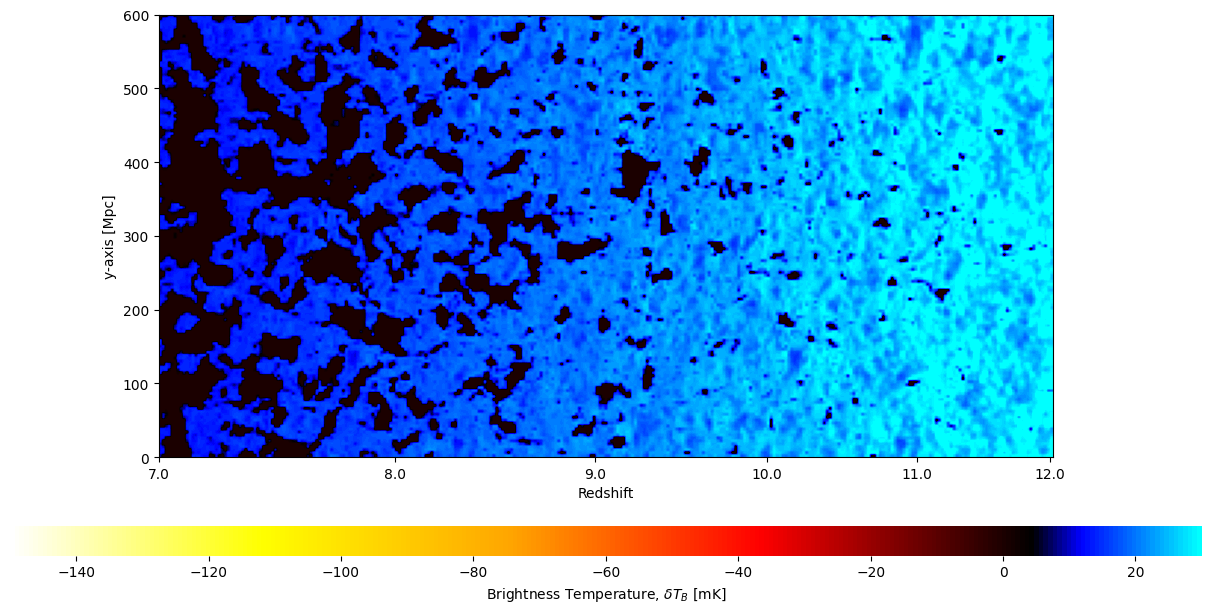

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
plotting.lightcone_sliceplot(lightcone, ax=ax, fig=fig);

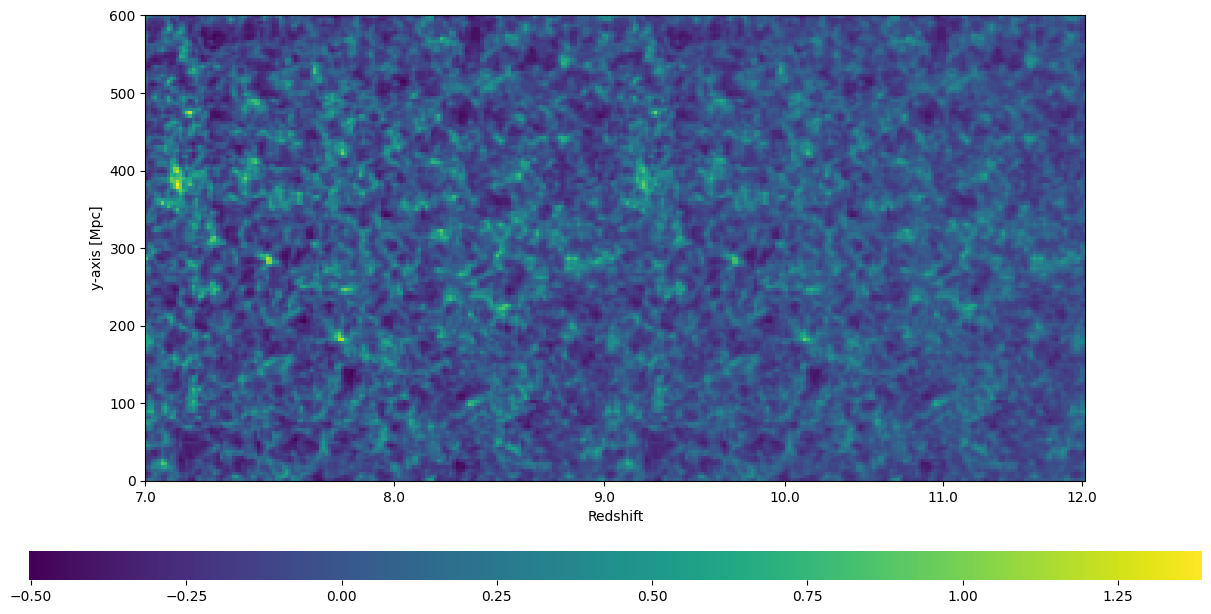

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)
plotting.lightcone_sliceplot(lightcone, 'density', ax=ax, fig=fig);

Simple!

## Using an Angular Lightcone

Say we would like to save our lightcone in angular coordinates. We can do this with the `AngularLightconer` subclass. This class requires you to pass a set of latitude (from $-\pi/2$ to $\pi/2$) and longitude (0 to 2$\pi$) points. It does not require these to be on a grid of any form (though often that is what you'll want). A common use-case would be to use a regular grid in (lat, lon) that roughly covers the coeval box size (at the low-z end). Another common use-case would be to use some subset of a HEALPix map (or maybe the full map, if you'd like to go on and use these simulations to produce visibilities!).

This lightconer is able to deal with full sky or any subset.

In this case, for ease of visualization, we will set up a regular (lon, lat) grid that is similar in size and resolution to our coeval box. Since we'd like to see the "transverse face" of the lightcone and see that it looks like the face of the rectilinear lightcone, we need to set a few options. First, set the angular region:

In [7]:
cosmo = lightcone.cosmo_params.cosmo

In [8]:
box_size_radians = user_params.BOX_LEN / cosmo.comoving_distance(7.0).value

In [9]:
lon = np.linspace(0, box_size_radians, user_params.HII_DIM)
lat = np.linspace(0, box_size_radians, user_params.HII_DIM)[::-1]  # This makes the X-values increasing from 0.

In [10]:
LON, LAT = np.meshgrid(lon, lat)
LON = LON.flatten()
LAT = LAT.flatten()

So far, we have just specified a small grid that should roughly line up with the coeval box, but it is close to the $x$-axis. Natively, the rectilinear lightcone uses the last axis (the $z$ axis) as the line-of-sight. We can use the options `origin` and `rotation` to align our specified co-ordinates with the rectilinear lightcone. 

The first operation applied is the `rotation`. In our case, we want to rotate our angles from being close to the $x$-axis, to instead being close to the $z$-axis (imagine a small squarish region of pixels perpendicular to and close to the $z$-axis). This means we need to rotate the co-ordinates by 90 degrees around the $y$-axis. Secondly, we apply an offset. The rectilinear lightcone is constructed in such a way that the first slice at the lowest redshift corresponds to the first slice along the $z$-axis. We achieve this by displacing the origin by the comoving distance to the minimum redshift. Note also that we constructed our initial latitude grid to go from high elevation down to the horizon. When the grid is rotated up to be close to the $z$-axis, this gets the $x$-coordinates going from left-to-right instead of the other way around.

In [11]:
offset = cosmo.comoving_distance(lightcone.lightcone_redshifts.min()).to(un.pixel, un.pixel_scale(user_params.cell_size/un.pixel))
origin = np.array([0, 0, offset.value])*offset.unit
rot = Rotation.from_euler('Y', -np.pi/2)

Now we can construct the lightconer, using the `AngularLightconer` class. Note that we specify that we want to get the line-of-sight velocity lightcone as well as our other quantities. This will allow us to apply RSDs to the temperature lightcone at the end.

In [12]:
ang_lcn = p21c.AngularLightconer.with_equal_cdist_slices(
    min_redshift=7.0,
    max_redshift=12.0,
    quantities=('brightness_temp', 'density'),
    resolution=user_params.cell_size,
    latitude=LAT,
    longitude=LON,
    origin=-origin,
    rotation=rot,
    get_los_velocity=True
)

Notice that we set `get_los_velocity` to True. This ensures that we take the 3D (coeval) velocities, and make a lightcone out of them where the field is the line-of-sight component (really line-of-sight, not just the third dimension of the coeval field). Setting this to True switches on application of RSDs in the `run_lightcone` function below, once all the lightcones have been computed.

Since it is a common thing to want to get an angular lightcone that "looks like" the coeval
box at some redshift, we provide a convenience method for creating it:

In [13]:
ang_lcn2 = p21c.AngularLightconer.like_rectilinear(
        match_at_z=7.0,
        max_redshift=12.0,
        user_params=user_params,
        get_los_velocity=True,
        quantities=("brightness_temp", "density"),
    )

This convenience method gives the same lightcone we manually got above:

In [14]:
ang_lcn == ang_lcn2

True

Once we have that, constructing the lightcone itself looks exactly the same as before, except that we need to turn off the RSDs. We apply RSDs to the angular lightcone itself, rather than to the coeval boxes that make it up. This is because the RSDs are applied in the transverse plane, and so we need to know the transverse co-ordinates of each pixel. This is not possible for a rectilinear lightcone, but is possible for an angular lightcone.

In [15]:
ang_lightcone = p21c.run_lightcone(
    lightconer=ang_lcn,
    global_quantities=("brightness_temp", 'density', 'xH_box'),
    direc='_cache',
    user_params=user_params, 
    flag_options={"APPLY_RSDS": False}
)

In this case, the output lightcone has a different type than the default rectilinear `Lightcone`:

In [16]:
type(ang_lightcone)

py21cmfast.outputs.AngularLightcone

The boxes in `ang_lightcone` have their transverse coordinates packed up into one dimension (because, again, there is no assumption that the angular coordinates were in a regular grid). In our specific case here, they *are* in a grid, so let's reshape the array to make it look like our rectilinear lightcone:

In [17]:
bt = ang_lightcone.brightness_temp.reshape((user_params.HII_DIM , user_params.HII_DIM, ang_lightcone.brightness_temp.shape[-1]))

Now we can plot the rectilinear and angular lightcones beside eachother to check that they are similar. Here we simply plot the face of the lightcone at the lowest redshift:

Text(0, 0.5, 'Transverse (y) dimension [cMpc]')

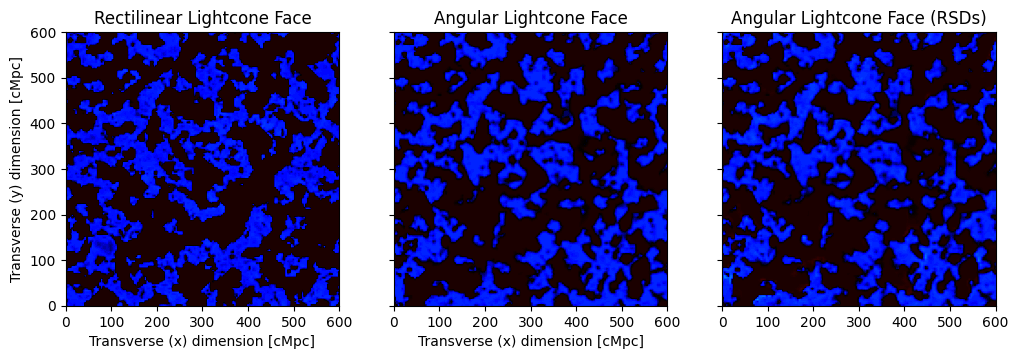

In [18]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,16))
ax[0].imshow(lightcone.brightness_temp[:, :, 0], origin='lower', extent=(0, user_params.BOX_LEN, 0, user_params.BOX_LEN), cmap='EoR', vmin=-150, vmax=30)
ax[0].set_title("Rectilinear Lightcone Face")
ax[1].imshow(bt[:, :, 0], origin='lower',extent=(0, user_params.BOX_LEN, 0, user_params.BOX_LEN), cmap='EoR', vmin=-150, vmax=30)
ax[1].set_title("Angular Lightcone Face")

btrsd = ang_lightcone.lightcones['brightness_temp_with_rsds'].reshape((user_params.HII_DIM , user_params.HII_DIM, ang_lightcone.brightness_temp.shape[-1]))
ax[2].imshow(btrsd[:, :, 0], origin='lower',extent=(0, user_params.BOX_LEN, 0, user_params.BOX_LEN), cmap='EoR', vmin=-150, vmax=30)
ax[2].set_title("Angular Lightcone Face (RSDs)")

ax[0].set_xlabel("Transverse (x) dimension [cMpc]")
ax[1].set_xlabel("Transverse (x) dimension [cMpc]")
ax[0].set_ylabel("Transverse (y) dimension [cMpc]")

In [24]:
lightcone_norsd = p21c.run_lightcone(
    lightconer=lcn,
    global_quantities=("brightness_temp", 'density', 'xH_box'),
    direc='_cache',
    user_params=user_params,
    flag_options={"APPLY_RSDS": False}
)

/data4/smurray/Projects/radio/EOR/OthersCodes/21cmFAST/21cmFAST-git/src/py21cmfast/inputs.py:510: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(
/data4/smurray/Projects/radio/EOR/OthersCodes/21cmFAST/21cmFAST-git/src/py21cmfast/_utils.py:821: UserWarning: Trying to remove array that isn't yet created: hires_vx
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/data4/smurray/Projects/radio/EOR/OthersCodes/21cmFAST/21cmFAST-git/src/py21cmfast/_utils.py:821: UserWarning: Trying to remove array that isn't yet created: hires_vy
  warnings.warn(f"Trying to remove array that isn't yet created: {k}")
/data4/smurray/Projects/radio/EOR/OthersCodes/21cmFAST/21cmFAST-git/src/py21cmfast/_utils.py:821

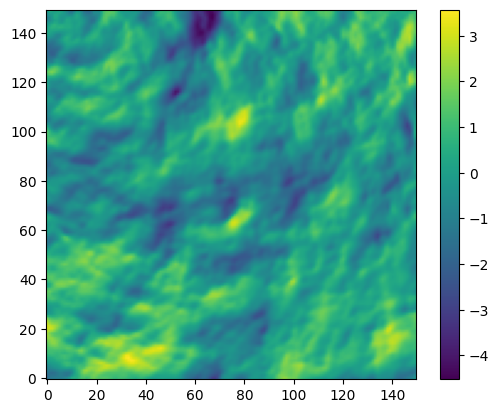

In [23]:
velocity_slice = ang_lightcone.lightcones['los_velocity'][:, 0].reshape((150,150))
plt.imshow((velocity_slice*un.Mpc/un.s / ang_lightcone.cosmo_params.cosmo.H(7.0)).to(un.Mpc), origin='lower')
plt.colorbar()

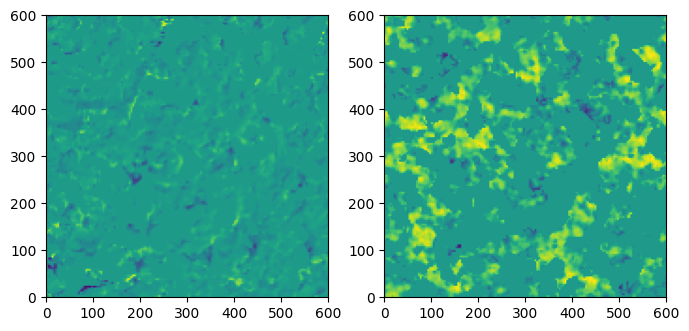

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(8, 12))

ax[0].imshow(bt[:, :, 0] - btrsd[:, :, 0], origin='lower',extent=(0, user_params.BOX_LEN, 0, user_params.BOX_LEN),)
ax[1].imshow(lightcone_norsd.brightness_temp[:, :, 0] - lightcone.brightness_temp[:, :, 0], origin='lower',extent=(0, user_params.BOX_LEN, 0, user_params.BOX_LEN),)


Here, we see the strong resemblence of each box to the other, especially in the upper left corner. The likeness grows weaker the further away from the upper left corner we move. This makes sense, as the angular lightcone face is curved, and only exactly corresponds to the rectilinear face on the one corner. 

We can also plot the evolution of the lightcone, choosing one transverse slice:

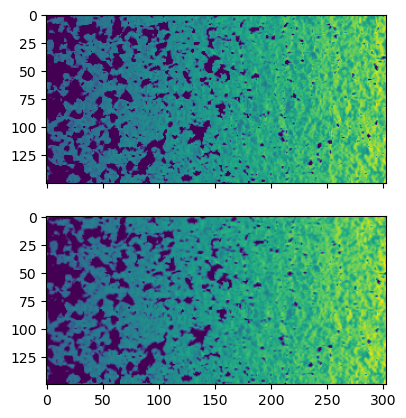

In [ ]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].imshow(lightcone.brightness_temp[:, 0])
ax[1].imshow(bt[:, 0])

Here we see a very similar evolution, since we have chosen a slice that corresponds best to the rectilinear lightcone.

We can get a more accurate representation of the angular lightcone by plotting it in polar coordinates. Here, we can just plot a slice corresponding to the horizon:

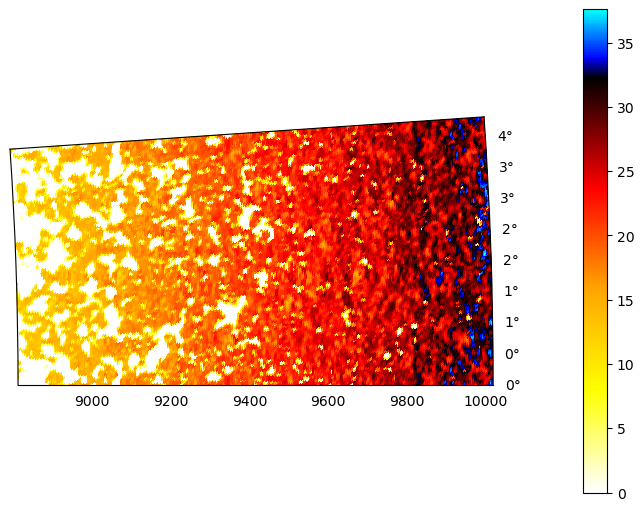

In [ ]:
fig, ax = plt.subplots(1,1,figsize=[14, 5], constrained_layout=True,subplot_kw={'projection': 'polar'})

ax.set_thetamax(lat.max() * 180/np.pi)
ax.set_ylim(ang_lcn.lc_distances.min(), ang_lcn.lc_distances.max())
ax.set_rorigin(0)
H, D = np.meshgrid(lat, ang_lcn.lc_distances)
plt.grid(False)
img = ax.pcolormesh(H, D, bt[:, 0].T,edgecolors='face', cmap='EoR')
plt.colorbar(img)


Here, the radial axis corresponds to comoving distance, and we have used the built-in "EoR" colormap provided by 21cmFAST.

So far, we have constructed our angular lightcone to be similar in size and resolution to the rectilinear lightcone. But as we've said, there is no restriction on the angular coordinates that can be put in. You could input the coordinates from a full-sky healpix map. To illustrate using a wider set of coordinates, let's create a "lightplane" taking a set of regular coordinates on the horizon, extending back into the line of sight. We do this for a wide angle (~22.5 degrees, or about 6 of our boxes stacked). In this case, we use no rotation or origin offset:

In [ ]:
lath = np.zeros(2000)
lonh = np.linspace(0, np.pi/8, 2000)

In [ ]:
ang_lcn_horiz = p21c.AngularLightconer.with_equal_cdist_slices(
    min_redshift=7.0,
    max_redshift=12.0,
    quantities=('brightness_temp', 'density'),
    user_params=user_params,
    latitude=lath,
    longitude=lonh,
)

In [ ]:
lc_horiz = ang_lightcone = p21c.run_lightcone(
    lightconer=ang_lcn_horiz,
    global_quantities=("brightness_temp", 'density', 'xH_box'),
    direc='_cache',
    user_params=user_params
)

When plotting, we add some grid lines identifying roughly the positions of the stacked underlying boxes (the one closest to the actual stacked coeval position is the one closest to $\theta=0$). 

/tmp/ipykernel_19088/996372940.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  img = ax.pcolormesh(H, D, lc_horiz.brightness_temp.T,edgecolors='face', cmap='EoR')


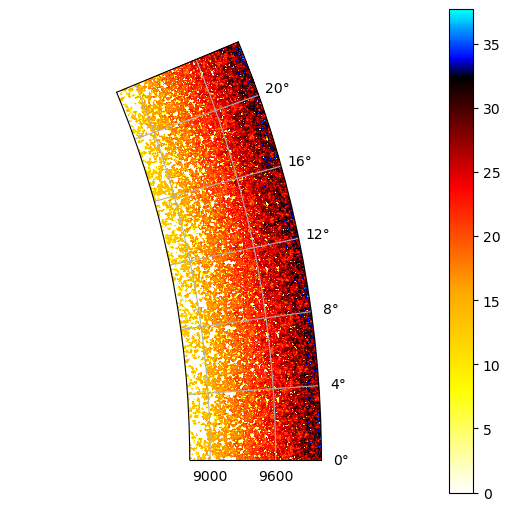

In [ ]:
fig, ax = plt.subplots(1,1,figsize=[5, 5], constrained_layout=True,subplot_kw={'projection': 'polar'})

theta = user_params.BOX_LEN / ang_lcn.cosmo.comoving_distance(ang_lcn.lc_redshifts.min()).value
nchunks = int(lonh.max() / theta) + 1
ax.set_thetamax(lonh.max() * 180/np.pi)
ax.set_ylim(ang_lcn.lc_distances.min(), ang_lcn.lc_distances.max())
ax.set_rorigin(0)
H, D = np.meshgrid(lonh, ang_lcn.lc_distances)
img = ax.pcolormesh(H, D, lc_horiz.brightness_temp.T,edgecolors='face', cmap='EoR')
plt.colorbar(img)

ax.set_thetagrids(np.arange(nchunks)*theta * 180/np.pi)
rgrid = np.arange(0, D.max(), user_params.BOX_LEN)
rgrid = rgrid[rgrid > D.min()]
ax.set_rgrids(rgrid)
ax.grid(True)


## Saving the Lightcones

You can easily save a HDF5 file containing the interpolated lightcone:

In [ ]:
filename = lightcone.save(direc='_cache', clobber=True)

In [ ]:
print(os.path.basename(filename))

LightCone_z7.0_15514a6677d48b8fea7b9687f8ad9881_r923466182270.h5


And for the angular lightcone:

In [ ]:
ang_filename = ang_lightcone.save(direc='_cache', clobber=True)

/data4/smurray/Projects/radio/EOR/OthersCodes/21cmFAST/21cmFAST-git/src/py21cmfast/inputs.py:508: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


In [ ]:
print(os.path.basename(ang_filename))

AngularLightcone_z7.0_15514a6677d48b8fea7b9687f8ad9881_r923466182270.h5
